In [1]:
casurl = 'https://lcps.nu/wp-content/uploads/'
casfil = 'covid-19.csv'

url = casurl + casfil
!wget -N $url

--2021-06-27 11:15:25--  https://lcps.nu/wp-content/uploads/covid-19.csv
Resolving lcps.nu (lcps.nu)... 2001:1460:3:0:1c00:d3ff:fe00:cb9, 62.221.199.13
Connecting to lcps.nu (lcps.nu)|2001:1460:3:0:1c00:d3ff:fe00:cb9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13310 (13K) [text/csv]
Saving to: ‘covid-19.csv’

covid-19.csv        100%[===================>]  13.00K  --.-KB/s    in 0s      

2021-06-27 11:15:25 (309 MB/s) - ‘covid-19.csv’ saved [13310/13310]



Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [2]:
import pandas as pd
import numpy as np

from pyearth import Earth
from pyearth import export

%matplotlib inline

We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format. Data for Namibia caused missing values because the `geoId` is __NA__, so we disable interpretation of missing values.

In [3]:
df = pd.read_csv(
    casfil,
#    keep_default_na=False,
#    na_values="",
    parse_dates=[0],
    dayfirst=True,
)
(
    df
    .head(10)
)

Datum  IC_Bedden_COVID  IC_Bedden_Non_COVID  Kliniek_Bedden  \
0 2021-06-26            141.0                575.0           198.0   
1 2021-06-25            147.0                599.0           216.0   
2 2021-06-24            158.0                571.0           234.0   
3 2021-06-23            170.0                578.0           255.0   
4 2021-06-22            185.0                573.0           277.0   
5 2021-06-21            197.0                541.0           294.0   
6 2021-06-20              NaN                  NaN             NaN   
7 2021-06-19              NaN                  NaN             NaN   
8 2021-06-18            218.0                565.0           315.0   
9 2021-06-17            226.0                580.0           347.0   

   IC_Nieuwe_Opnames_COVID  Kliniek_Nieuwe_Opnames_COVID  
0                      3.0                          19.0  
1                      2.0                           9.0  
2                      1.0                          11.0  
3                      5.0                          24.0  
4                      4.0                          19.0  
5                      5.0                          12.0  
6                      NaN                           NaN  
7                      NaN                           NaN  
8                      4.0                          32.0  
9                      5.0                          32.0

Adding structure and dummy variables, last check of our source dataframe.

In [4]:
df["Source"] = "LCPS"
df["Capacity"] = 1  # placeholder, not used currently
df["IC_totaal"] = (
    (
        df
        ["IC_Bedden_COVID"]
    )
    +
    (
        df
        ["IC_Bedden_Non_COVID"]
    )
)
(
    df
    .describe()
    .transpose()
)

count         mean         std    min     25%  \
IC_Bedden_COVID               484.0   445.285124  336.970453    7.0   91.00   
IC_Bedden_Non_COVID           433.0   495.362587   69.450890  344.0  439.00   
Kliniek_Bedden                484.0  1111.347107  759.970839    1.0  292.75   
IC_Nieuwe_Opnames_COVID       251.0    33.984064   14.408322    1.0   24.00   
Kliniek_Nieuwe_Opnames_COVID  251.0   193.653386   74.526206    9.0  154.50   
Capacity                      486.0     1.000000    0.000000    1.0    1.00   
IC_totaal                     433.0   915.672055  227.399191  537.0  662.00   

                                 50%      75%     max  
IC_Bedden_COVID                519.0   658.25  1424.0  
IC_Bedden_Non_COVID            493.0   554.00   646.0  
Kliniek_Bedden                1298.5  1670.25  3284.0  
IC_Nieuwe_Opnames_COVID         35.0    44.00    76.0  
Kliniek_Nieuwe_Opnames_COVID   199.0   241.00   430.0  
Capacity                         1.0     1.00     1.0  
IC_totaal                      995.0  1085.00  1557.0

We pivot to a source by column format.

In [5]:
# File parameters prefixed pf_

pf_datcol = "Datum"  # date column
pf_dimcol = "Source"  # dimension column (location or otherwise)
pf_cascol = [
    "IC_Nieuwe_Opnames_COVID",
    "Kliniek_Nieuwe_Opnames_COVID",
]
pf_namcol = "Source"  # full dim name
pf_popcol = "Capacity"  # population column

pf_futext = "365 days"  # future extension of dataframe

In [6]:
df_dim = (
    df
    .pivot_table(
        index=pf_datcol,
        columns=pf_dimcol,
        values=pf_cascol,
        aggfunc="sum",
    )
    .fillna(0)
    .swaplevel(axis=1)
)
df_dim

Source                        LCPS                             
           IC_Nieuwe_Opnames_COVID Kliniek_Nieuwe_Opnames_COVID
Datum                                                          
2020-02-27                     0.0                          0.0
2020-02-28                     0.0                          0.0
2020-02-29                     0.0                          0.0
2020-03-01                     0.0                          0.0
2020-03-02                     0.0                          0.0
...                            ...                          ...
2021-06-22                     4.0                         19.0
2021-06-23                     5.0                         24.0
2021-06-24                     1.0                         11.0
2021-06-25                     2.0                          9.0
2021-06-26                     3.0                         19.0

[486 rows x 2 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [7]:
new_index = pd.date_range(
    (
        df_dim
        .index
        .min()
    ),
    (
        df_dim
        .index
        .max()
        + pd.Timedelta(pf_futext)
    ),
)
df_dim = (
    df_dim
    .reindex(new_index)
)
df_dim

Source                        LCPS                             
           IC_Nieuwe_Opnames_COVID Kliniek_Nieuwe_Opnames_COVID
2020-02-27                     0.0                          0.0
2020-02-28                     0.0                          0.0
2020-02-29                     0.0                          0.0
2020-03-01                     0.0                          0.0
2020-03-02                     0.0                          0.0
...                            ...                          ...
2022-06-22                     NaN                          NaN
2022-06-23                     NaN                          NaN
2022-06-24                     NaN                          NaN
2022-06-25                     NaN                          NaN
2022-06-26                     NaN                          NaN

[851 rows x 2 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [8]:
df_dim["daynum"] = (
    (
        (
            df_dim
            .index
        )
        -
        (
            df_dim
            .index
            .min()
        )
    )
    .days
)
(
    df_dim
    ["daynum"]
    .describe()
)

count    851.000000
mean     425.000000
std      245.806835
min        0.000000
25%      212.500000
50%      425.000000
75%      637.500000
max      850.000000
Name: daynum, dtype: float64

The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`.

In [9]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = -((x - mu) / beta)
    return np.exp(expon) * np.exp(-(np.exp(expon))) / beta

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = -((x - mu) / beta)
    return np.exp(-(np.exp(expon)))

In [10]:
# Run parameters prefixed pr_

pr_measure = "LCPS"  # file column to use as measure
pr_smeasure = "Week window"  # smoothed measures
pr_rmeasure = "rcases"  # remaining measures after iteration
pr_pmeasure = "Model"  # projected measures summed
pr_wmeasure = "Wave "  # wave name prefix, zero-leading number is added
pr_wavenum = 2  # wave numbering width

pr_sdays = 7  # number of days for smoothing window
pr_firstwav = 1  # initial wave number
pr_popcases = 1e6  # relative minimum from population size (one in n cases)
pr_mincases = 2  # absolute minimum number of cases to consider

pr_linmax = -8/20  # upper bound of linear derivation
pr_linmin = -8/2  # lower bound of linear derivation
pr_betamax = 80/2  # maximum accepted beta estimate
pr_datamin = 3  # minimum number of data points in spline
pr_projmin = 1  # minimum cases for projected start and floor
pr_gradmin = 1e-6  # minimum gradient difference for knot

pr_plotmin = "20201001"  # start date of output plots
pr_plotmax = "20210901"  # final date of output plots

pr_earth = {
    "minspan": 1,
    "penalty": 0,
    "endspan": 0,
    "thresh": 1e-9,
    "check_every": 1
}

Running multiple wave analysis for IC_Nieuwe_Opnames_COVID
Minimum number of cases is 2
Wave 01 beta  5.689 mu 241 fit 0.828 peak 2020-10-25 from 2020-10-15 to 2020-11-22 size 695
Wave 02 beta  6.559 mu 253 fit 0.858 peak 2020-11-06 from 2020-10-26 to 2020-12-07 size 650
Wave 03 beta  9.208 mu 273 fit 0.887 peak 2020-11-26 from 2020-11-10 to 2021-01-04 size 644
Wave 04 beta  5.679 mu 290 fit 0.945 peak 2020-12-13 from 2020-12-04 to 2021-01-04 size 261
Wave 05 beta  5.804 mu 299 fit 0.884 peak 2020-12-22 from 2020-12-12 to 2021-01-16 size 405
Wave 06 beta  7.991 mu 312 fit 0.827 peak 2021-01-04 from 2020-12-20 to 2021-02-10 size 807
Wave 07 beta  5.145 mu 326 fit 0.818 peak 2021-01-18 from 2021-01-09 to 2021-02-08 size 276
Wave 08 beta  5.221 mu 335 fit 0.876 peak 2021-01-27 from 2021-01-19 to 2021-02-17 size 261
Wave 09 beta  4.874 mu 342 fit 0.848 peak 2021-02-03 from 2021-01-26 to 2021-02-21 size 194
Wave 10 beta  4.831 mu 351 fit 0.859 peak 2021-02-12 from 2021-02-05 to 2021-03-02 s

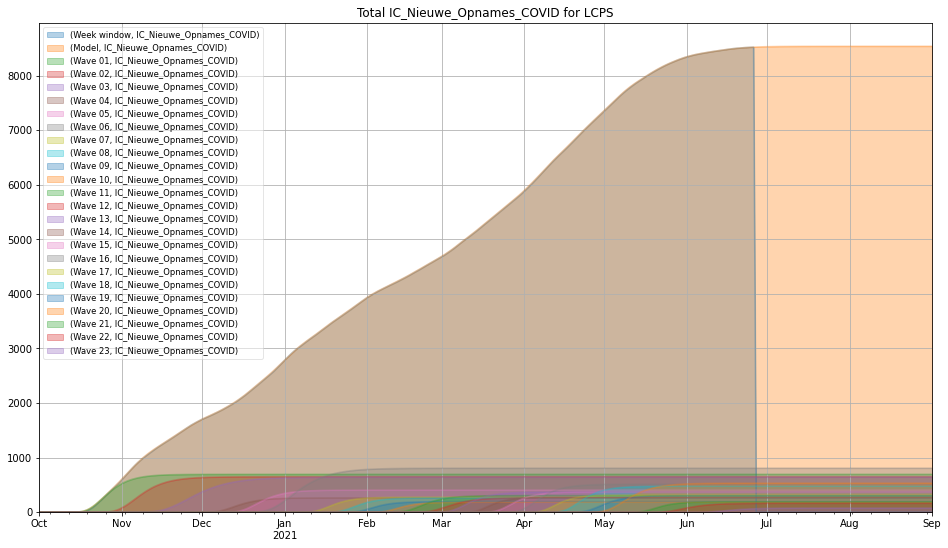

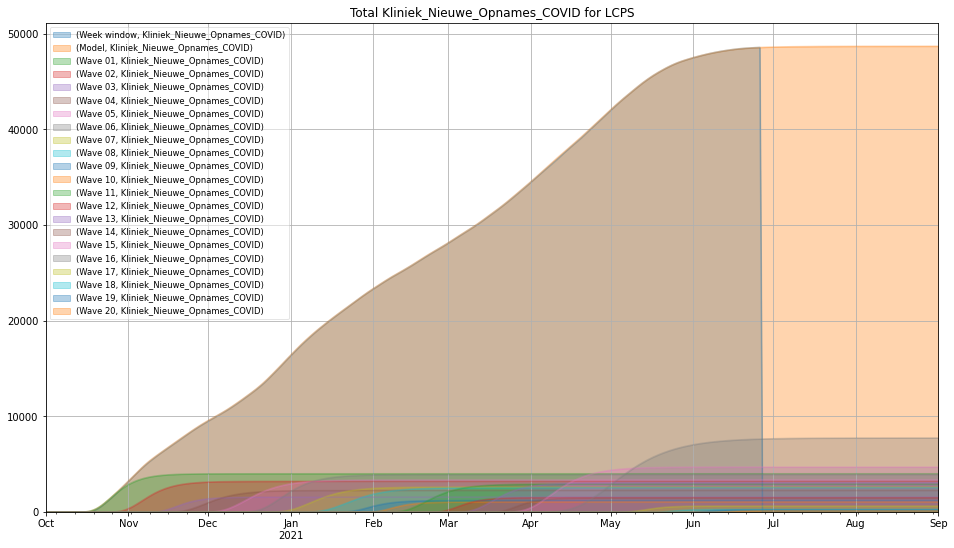

In [11]:
dimlist = pf_cascol

for pr_dim in dimlist:

    wave = pr_firstwav

    # Initialize predicted measure, create smoothed measure and remaining cases
    df_dim[(pr_pmeasure, pr_dim)] = 0
    df_dim[(pr_smeasure, pr_dim)] = (
        df_dim
        [pr_measure]
        [pr_dim]
        .loc[:]
        .rolling(pr_sdays)
        .mean()
    )
    df_dim[(pr_rmeasure, pr_dim)] = (
        df_dim
        [pr_smeasure]
        [pr_dim]
    )

    # Always plot smoothed and predicted measures, adding waves when found
    plotlist = [
        (pr_smeasure, pr_dim),
        (pr_pmeasure, pr_dim),
    ]

    # Get full name and population from the original dataset
    # dimnam = df[df[pf_dimcol] == pr_dim][pf_namcol].iloc[0]
    # dimpop = df[df[pf_dimcol] == pr_dim][pf_popcol].iloc[0]

    # We use relative minimum cases, but at least an absolute minimum
    mincases = pr_mincases

    print(
        "Running multiple wave analysis for {}"
        .format(
            pr_dim,
        )
    )
    print(
        "Minimum number of cases is {:1.0f}"
        .format(
            mincases,
        )
    )

    while True:
        # Create potential wave
        curwave = (
            pr_wmeasure
            + str(
                wave
                + (10 ** pr_wavenum)
            )
            [-pr_wavenum:]
        )
        df_dim[(curwave, pr_dim)] = 0

        # Create a dataframe for projections
        df_proj = pd.DataFrame(
            {
                "daynum": (
                    df_dim
                    ["daynum"]
                ),
                "measure": (
                    df_dim
                    [pr_rmeasure]
                    [pr_dim]
                ),
            }
        )

        # Create the Gumbel division and select suitable measures
        df_proj["gumdiv"] = (
            (
                df_proj
                ["measure"]
            )
            /
            (
                df_proj
                ["measure"]
                .cumsum()
            )
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ["gumdiv"]
                    > 0
                )
                &
                (
                    df_proj
                    ["measure"]
                    > mincases
                )
            ]
        )

        # Reduce to log scale and select relevant measures
        df_proj["linear"] = np.log(
            df_proj
            ["gumdiv"]
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ["linear"]
                    < pr_linmax
                )
                &
                (
                    df_proj
                    ["linear"]
                    > pr_linmin
                )
            ]
        )

        # Do we still have data left?
        if len(df_proj) <= 1:
            print("--- no data left")
            break

        # Create input vectors for regression splines and build a model
        eax = (
            df_proj
            ["daynum"]
            .values
            .reshape(-1, 1)
        )
        eay = (
            df_proj
            ["linear"]
            .values
            .reshape(-1, 1)
        )
        eamodel = Earth(
            **pr_earth,
        )
        (
            eamodel
            .fit(
                eax,
                eay,
            )
        )

        # Store the results
        df_proj["earth"] = (
            eamodel
            .predict(
                eax,
            )
        )

        # Find the day range
        daymin = (
            df_proj
            ["daynum"]
            .min()
        )
        daymax = (
            df_proj
            ["daynum"]
            .max()
        )

        # Find the gradient of generated regression splines
        df_proj["eagrad"] = (
            (
                df_proj
                ["earth"]
            )
            -
            (
                df_proj
                ["earth"]
                .shift(1)
            )
        )

        # Knots are found when the gradient changes, including start and end
        df_proj["knot"] = (
            (
                abs(
                    (
                        df_proj
                        ["eagrad"]
                    )
                    -
                    (
                        df_proj
                        ["eagrad"]
                        .shift(1)
                    )
                )
                > pr_gradmin
            )
            | 
            (
                df_proj
                ["daynum"]
                == (daymin + 1)
            )
            |
            (
                df_proj
                ["daynum"]
                == daymax
            )
        )

        # Starting day of each spline
        df_proj["daycount"] = (
            df_proj
            .reset_index()
            .index
        )

        # Select the knots and find the actual number of days for each spline
        df_knot = (
            df_proj
            [
                df_proj
                ["knot"]
            ]
            [
                [
                    "daynum",
                    "daycount",
                    "eagrad",
                ]
            ]
        )
        df_knot["daysdata"] = (
            (
                df_knot
                ["daycount"]
                .shift(-1)
            )
            -
            (
                df_knot
                ["daycount"]
            )
        )

        # Candidate knots have a negative gradient and a minimum number of days
        df_knot["cand"] = (
            (
                df_knot
                ["eagrad"]
                < -(1 / pr_betamax)
            )
            &
            (
                df_knot
                ["daysdata"]
                >= pr_datamin
            )
        )

        # We want early knots with a low gradient and many days
        df_knot["since"] = (
            df_knot
            ["daynum"]
            - daymin
        )
        df_knot["score"] = (
            (
                df_knot
                ["eagrad"] 
                ** 2
            )
            * 
            np.sqrt(
                (
                    df_knot
                    ["daysdata"]
                )
                / 
                np.sqrt(
                    df_knot
                    ["since"]
                )
            )
        )
        df_knot["choice"] = (
            (
                df_knot
                ["score"]
            )
            == 
            (
                df_knot
                [
                    df_knot
                    ["cand"]
                ]
                ["score"]
                .max()
            )
        )

        # Did we find another wave?
        choice = (
            df_knot
            [
                df_knot
                ["choice"]
            ]
        )
        if len(choice) == 0:
            print("--- no data for wave")
            break

        # Find the interval of the selected spline
        lower = (
            choice
            ["daynum"]
            .values[0]
        )
        upper = (
            choice
            ["daysdata"]
            .values[0]
            + lower
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ["daynum"]
                    >= lower
                )
                & 
                (
                    df_proj
                    ["daynum"]
                    <= upper
                )
            ]
            .copy()
        )

        # Calculate slope and intercept as basis for beta and mu
        fitmod = export.export_python_function(eamodel)
        slope = (
            (
                fitmod([[upper]])[0] 
                - fitmod([[lower]])[0]
            )
            / 
            (
                upper
                - lower
            )
        )
        intercept = (
            fitmod([[lower]])[0]
            - (lower * slope)
        )
        beta = -1 / slope
        mu = beta * (intercept + np.log(beta))

        # Apply the Gumbel PDF according to beta and mu to find the scale and fit
        df_proj["pgumb"] = gumpdf(
            (
                df_proj
                ["daynum"]
            ),
            beta,
            mu,
        )
        df_proj["scale"] = (
            (
                df_proj
                ["measure"]
            )
            /
            (
                df_proj
                ["pgumb"]
            )
        )
        final = (
            df_proj
            ["scale"]
            .mean()
        )
        fincv = (
            df_proj
            ["scale"]
            .std()
            / final
        )

        # Calculate the current wave and its parameters
        df_dim[(curwave, pr_dim)] = (
            gumpdf(
                (
                    df_dim
                    ["daynum"]
                ),
                beta,
                mu,
            )
            * final
        )
        peak = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                )
                == 
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .max()
                )
            ]
            .index
            .min()
        )
        start = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    >= pr_projmin
                )
                &
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .index 
                    < peak
                )
            ]
            .index
            .min()
        )
        floor = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    < pr_projmin
                )
                &
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .index
                    > peak
                )
            ]
            .index
            .min()
        )
        print(
            "{} beta {:6.3f} mu {:3.0f} fit {:5.3f} peak {} from {} to {} size {:1.0f}"
            .format(
                curwave,
                beta,
                mu,
                (1 - fincv) ** 2,
                peak.date(),
                start.date(),
                floor.date(),
                final,
            )
        )

        # Move the associated measures from remainder to prediction
        df_dim[(pr_pmeasure, pr_dim)] += (
            df_dim
            [(curwave, pr_dim)]
        )
        df_dim[(pr_rmeasure, pr_dim)] -= (
            df_dim
            [(curwave, pr_dim)]
        )
        plotlist += [(curwave, pr_dim)]
        wave += 1

    (
        df_dim
        [plotlist]
        .loc[pr_plotmin:pr_plotmax]
        .plot(
            figsize=(16, 9),
            grid=True,
            kind="area",
            stacked=False,
            alpha=1/3,
            title=(
                pr_dim
                + " for "
                + pr_measure
            ),
        )
        .legend(
            loc='upper left',
            fontsize='small',
            framealpha=1/2,
        )
    )
    (
        df_dim
        [plotlist]
        .loc[pr_plotmin:pr_plotmax]
        .cumsum()
        .plot(
            figsize=(16, 9),
            grid=True,
            kind="area",
            stacked=False,
            alpha=1/3,
            title=(
                "Total "
                + pr_dim 
                + " for " 
                + pr_measure
            ),
        )
        .legend(
            loc='upper left',
            fontsize='small',
            framealpha=1/2,
        )
    )

In [12]:
for pr_dim in dimlist:
    (
        (
            (
                df_dim
                [pr_smeasure]
                [pr_dim]
            )
            -
            (
                df_dim
                [pr_pmeasure]
                [pr_dim]
            )
        )
        .loc[pr_plotmin:pr_plotmax]
        .plot(
            figsize=(16, 9),
            grid=True,
            title=(
                "Residuals for "
                + pr_measure
            ),
        )
        .legend(loc='upper left')
    )

Keep exploring! Stay home, wash your hands, keep your distance.